# ConvAE_Recom

## 0. Setting

In [1]:
pwd

'C:\\myPyCode\\Graduation_Project'

In [2]:
ls

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: A494-C8A8

 C:\myPyCode\Graduation_Project 디렉터리

2022-10-21  오후 05:36    <DIR>          .
2022-10-21  오후 05:36    <DIR>          ..
2022-10-15  오후 04:42    <DIR>          .ipynb_checkpoints
2022-10-14  오후 04:26    <DIR>          ConvAE_Recom
2022-10-21  오후 05:36           877,280 ConvAE_Recom.ipynb
2022-10-17  오후 05:22             2,811 Notey.txt
2022-10-12  오후 02:20    <DIR>          YOLOv5
2022-10-21  오후 05:36            88,106 Yolov5 WebCam.ipynb
               3개 파일             968,197 바이트
               5개 디렉터리  38,806,614,016 바이트 남음


### Library Call

In [3]:
# 상용 라이브러리
from glob import glob
import os
import cv2
import pandas as pd
import numpy as np
import datetime as dt
import time
import json

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

# Similarity Metrics
from sklearn.metrics.pairwise import cosine_similarity

### User Function & Constant Definition

In [4]:
# -------------Image Load & Preprocessing ------------- #
# Global Constant Definition
imgR = 128
imgC = 128
channel = 3
zero_padding = 14
root_dir = 'C:/myPyCode/Graduation_Project'
usb_dir = 'D:/'

# Single Image Load
def img_read(file):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Gamma Correction
def adjust_gamma(img, gamma=1.0): # 감마 보정 함수
    invGamma = 1.0 / gamma
    out = img.copy().astype(np.float)
    out = ((out / 255) ** invGamma) * 255
    return out.astype(np.uint8)

# Image Crop & Resize
def img_crop(img, name, x1,x2,y1,y2):
    img = img[y1:y2,x1:x2]
    
    # 상의일 경우 비율을 7:10으로 조정
    if (name == 'shirt') or (name == 'outwear'):
        img = cv2.resize(img, (imgR-zero_padding*2,int((imgC-zero_padding*2)*0.7)), interpolation=cv2.INTER_CUBIC)
    # 하의일 경우 비율을 10:6으로 조정
    elif name == 'trousers':
        img = cv2.resize(img, (int((imgR-zero_padding*2)*0.6),imgC-zero_padding*2), interpolation=cv2.INTER_CUBIC)
    # 예외처리 : 정사이즈
    else:
        img = cv2.resize(img, (imgR-zero_padding*3,imgC-zero_padding*3), interpolation=cv2.INTER_CUBIC)
        
    print(img.shape, name)
    return img

# Image Contrast
def img_contrast(img):
    # Converting image to LAB Color model
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # Splitting the LAB image to different channels
    l, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2, 2))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl, a, b))

    # Converting image from LAB Color model to RGB model
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    return final

# Image Zero-Padding
def img_zero_padding(img):
    dx, dy = int((imgR-img.shape[0])/2), int((imgC-img.shape[1])/2)
    img = cv2.copyMakeBorder(img,dx,dx,dy,dy,
                             cv2.BORDER_CONSTANT,value=[255,255,255])
    return img

# Remove Background
def remove_background(img,x1,x2,y1,y2):
    w = x2-x1
    h = y2-y1
    rectangle = (x1,y1,w,h)
    mask = np.zeros(img.shape[:2],np.uint8)

    # grabCut에 사용할 임시 배열 생성
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # grabCut 실행
    cv2.grabCut(img, # 원본 이미지
               mask,       # 마스크
               rectangle,  # 사각형
               bgdModel,   # 배경을 위한 임시 배열
               fgdModel,   # 전경을 위한 임시 배열 
               5,          # 반복 횟수
               cv2.GC_INIT_WITH_RECT) # 사각형을 위한 초기화
    
    # 배경인 곳은 0, 그 외에는 1로 설정한 마스크 생성
    mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
    
    # 이미지에 새로운 마스크를 곱행 배경을 제외
    result = img * mask_2[:, :, np.newaxis]
    
    # 부식과 팽창
    erode=cv2.erode(mask_2, None, iterations=1)
    dilate=cv2.dilate(erode, None, iterations=1)
    
    # 흰 배경으로 이미지 합성
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            if dilate[i,j]==0:
                result[i,j]=(255,255,255)
    
    return result

# Load All img from folder
def load_img_folder():
    wfiles = glob(f'{root_dir}/YOLOv5/yolov5/runs/detected_capture/*.jpg')
    img_list, label_list = [], []
    for file in wfiles:
        #label
        label = file.split('\\')[-1][:-4]
        name = label.split('-')[0]
        x1,x2,y1,y2 = list(map(int,label.split('-')[-1].split('.')))
        label_list.append(label)
        
        #img
        img = img_read(file)
        img = remove_background(img,x1,x2,y1,y2)        
        img = img_contrast(img)
        img = img_crop(img,name,x1,x2,y1,y2)
#         img = cv2.add(img,(10,10,10,0))
        img = adjust_gamma(img, 0.8)
        img = img_zero_padding(img)
        img_list.append(img)
    return np.array(img_list)

# -------------Image EDA & Visualization ------------- #
# plot_images
def plot_images(nRow, nCol, img_set):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize=(nCol*4,nRow*4))
    k=0
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1 : axis = ax[j]
            else:          axis = ax[i,j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img_set[k+j])
            plt.axis('off')
        k += nCol
    plt.show()
    
# Top 10 Similar Images Visualization
def top10_visualize(top10_label_cosine):
    count = 0
    fig = plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(5*5,2*5))
    plt.suptitle('Top10 Similar Images!!', size=30)
    for i in range(2):
        for j in range(5):
            axis = ax[i,j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            try:
                img_name = top10_label_cosine[i+j]
                img = img_read(usb_dir + 'Images/Item-Image/' + img_name)
                axis.imshow(img)
                plt.axis('off')
            except:
                pass
            count+=1
    plt.show()

# Model Image Recommendation Result Visualization
def Recommendation_Result_Visualization(recomm_total):
    fig = plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(5*5,2*5))
    plt.suptitle('Fashion Best Fit Recommendatation!!', size=30)
    count=0
    patience=0
    idx = 0
    while True:
        i,j = count//5, count%5
        axis = ax[i,j]
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
        try:
            fashion_img_name = recomm_total.iloc[idx,0]
            img = img_read(root_dir + '/ConvAE_Recom/data/Model-Image/' + fashion_img_name)
            axis.imshow(img)
            plt.axis('off')
            count+=1
        except:
            patience += 1
        idx+=1
        if (patience > 10) or (count >= 10):
            break
    plt.show()
    
# ------------- Model Function ------------- #
# Reconstruction Error Function Definition
def Reconstruction_Error(X_test,X_pred):
    error_list = []
    for i in range(len(X_test)):
        ele = np.mean(np.power(X_test[i] - X_pred[i], 2),axis=1).mean()
        error_list.append(ele)
    return error_list

# Average Pooling Fuction Definition
def AVGpooling(raw_feature):
    result = []
    for i in range(raw_feature.shape[0]):
        row= []
        for j in range(raw_feature.shape[-1]):
            row.append(raw_feature[i,:,:,j].mean())
        result.append(row)
    return np.array(result)

# ------------- Recommendation System ------------- #
def Fashion_coordination(top10_result, fashion_df):
    result_df = []
    for item in top10_result:
        ele_df = pd.DataFrame(columns=fashion_df.columns)
        for col in fashion_df.columns:
            ele = fashion_df[fashion_df[col] == item]
            ele_df = pd.concat([ele_df,ele])
        result_df.append(ele_df)
    return result_df

## 1. Detected Images Load

In [5]:
# Detected Images Load
img_set = load_img_folder()
print('detected images.shape :',img_set.shape)

(70, 100, 3) shirt
(100, 60, 3) trousers
detected images.shape : (2, 128, 128, 3)


In [6]:
# Image Information
type(img_set), round(img_set.mean(),4)

(numpy.ndarray, 191.073)

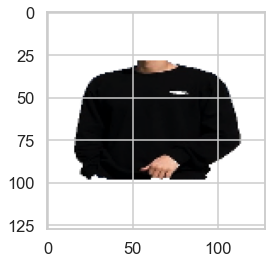

In [7]:
# Plot Single Image Sample
plt.imshow(img_set[0])
plt.show()

<Figure size 432x288 with 0 Axes>

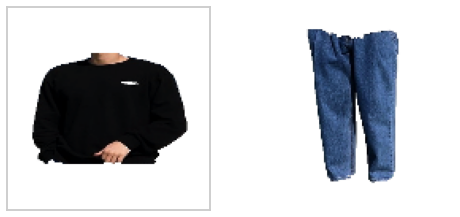

In [8]:
# Multi Image Samples
_ = plot_images(1,img_set.shape[0],img_set)

## 2. Data Preprocessing

In [9]:
# Data Normalization
img_scaled = img_set / 255.0
print('Raw Image Format :',img_set.shape, img_set.mean())
print('Scaled Image Format :',img_scaled.shape, img_scaled.mean())

Raw Image Format : (2, 128, 128, 3) 191.07300821940103
Scaled Image Format : (2, 128, 128, 3) 0.7493059145858864


## 3. Applying ConvAE

In [10]:
# Load Model
encoder = keras.models.load_model('ConvAE_Recom/model_selected/Encoder_128x128')
decoder = keras.models.load_model('ConvAE_Recom/model_selected/Decoder_128x128')
model = keras.models.load_model('ConvAE_Recom/model_selected/ConvAE_128x128')

In [11]:
# ConvAE Prediction(Reconstruction)
img_recon = model.predict(img_scaled)
img_recon.shape,round(img_recon.mean(),4)

1/1 [==============================] - 0s 424ms/step


((2, 128, 128, 3), 0.7319)

<Figure size 432x288 with 0 Axes>

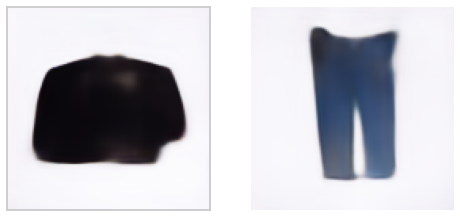

In [12]:
# Reconstruction Image Samples
_ = plot_images(1,img_set.shape[0],img_recon)

In [13]:
# Reconstruction Error 
img_error = Reconstruction_Error(img_scaled,img_recon)
len(img_error), type(img_error)

(2, list)

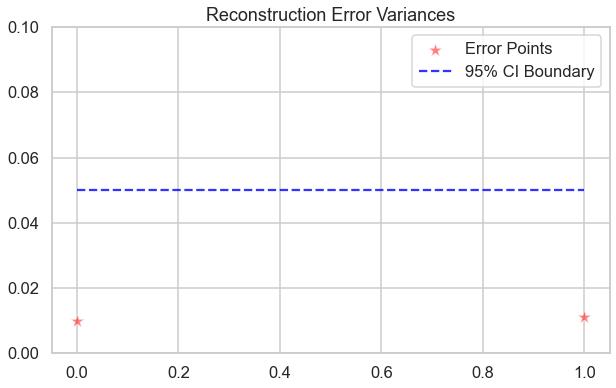

In [14]:
# Reconstruction Error Visaulization
X_loop = np.arange(len(img_error))
boundary = 0.05

plt.figure(figsize=(10,6))
sns.scatterplot(X_loop, img_error, color = 'red', alpha=0.5, marker='*', label='Error Points', s=200)
sns.lineplot(X_loop, boundary, color='blue', linestyle='--', label='95% CI Boundary', alpha=0.8)
plt.title('Reconstruction Error Variances', size=18)
plt.legend(loc="upper right")
plt.ylim(0.00,0.10)
plt.show()

## 4. Latent Space Projection

In [15]:
# Raw Latent Feature
raw_feature = encoder.predict(img_scaled)
raw_feature.shape, type(raw_feature)

1/1 [==============================] - 0s 193ms/step


((2, 4, 4, 8), numpy.ndarray)

In [16]:
# Deep Compact Latent 8 Features 
latent_feature = AVGpooling(raw_feature)
latent_feature.shape, type(latent_feature)

((2, 8), numpy.ndarray)

In [17]:
# Latent Feature DataFrame
comp_list = ['comp1','comp2','comp3','comp4','comp5','comp6','comp7','comp8']
img_comp_df = pd.DataFrame(latent_feature)
img_comp_df.columns = comp_list
print('img_comp_df.shape :',img_comp_df.shape)
img_comp_df.head()

img_comp_df.shape : (2, 8)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8
0,8.069803,6.291930,6.092497,3.192018,2.793842,11.149190,2.787916,6.773251
1,5.556969,3.765855,5.491287,2.565197,2.505104,7.740993,2.403861,4.923080


## 5. Similarity Calculation & Top10 Item Recommendation

In [18]:
# Latent Feature DataFrame load D:\Fasion_Images
df = pd.read_csv('ConvAE_Recom/latent_feature/latent_feature_128x128.csv')
stop_item = ['1117081_F.jpg','1109034_F.jpg','1118386_F.jpg','1021160_F.jpg','1021032_F.jpg','1109032_F.jpg','1015044_F.jpg','1014205_F.jpg','1014173_F.jpg','1015345_F.jpg','1020250_F.jpg','1014237_F.jpg','1014040_F.jpg','1021018_F.jpg','1026258_F.jpg','1014178_F.jpg','1015534_F.jpg','1016230_F.jpg','1016239_F.jpg','1015256_F.jpg','1124371_F.jpg','1026298_F.jpg','1015336_F.jpg','1019253_F.jpg','1118321_F.jpg','1027349_F.jpg','1021153_F.jpg','1021154_F.jpg','1208281_F.jpg','1125284_F.jpg','1014313_F.jpg','1015419_F.jpg','1021085_F.jpg','1015159_F.jpg','1109036_F.jpg','1016292_F.jpg','1021207_F.jpg','1110322_F.jpg']
stop_list = df[df['label'].isin(stop_item)].index.tolist()
df.drop(stop_list,inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head()

(16547, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,1.816822,1.886551,1.807105,0.858414,1.428525,2.295357,0.791543,1.505969,0928015_F.jpg
1,1.904211,1.930044,1.972450,0.783947,1.302266,2.407675,0.821974,1.499656,0929029_F.jpg
2,6.471252,6.036780,5.894671,2.869880,2.186035,10.727018,2.532120,5.862957,1008001_F.jpg
3,5.119862,4.681663,5.019187,2.043906,1.902202,7.571554,1.737040,4.642845,1008004_F.jpg
4,4.114837,3.997970,3.995601,1.616894,1.459364,5.931483,1.358331,3.653468,1008006_F.jpg


In [19]:
# Latent Feature Data & Label Split
data = df.drop('label',axis=1)
label = df['label']
print(data.shape, label.shape)

(16547, 8) (16547,)


In [20]:
# data downcasting
data = data.astype('float32')

In [23]:
# Single Image Extraction
samp_idx = 0
sample = img_comp_df.iloc[samp_idx].to_numpy().reshape(1,-1)
print('sample:',sample.shape)

sample: (1, 8)


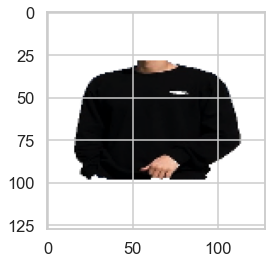

In [24]:
# Single Sample Visualization
_ = plt.imshow(img_set[samp_idx])

In [25]:
# Cosine Similarity of Single Sample
sample_cosine_sim = cosine_similarity(sample, data)

print('sample_cosine_sim.shape :',sample_cosine_sim.shape)

sample_cosine_sim.shape : (1, 16547)


In [26]:
# Define Sample Similarity DataFrame
df_cosine = pd.DataFrame(sample_cosine_sim.T, index=df.index, columns=['sample'])
print('df_cosine.shape :',df_cosine.shape)
df_cosine.head(4)

df_cosine.shape : (16547, 1)


,sample
0,0.975298
1,0.979510
2,0.997271
3,0.996756


In [27]:
# Return Top10 Similar Items
top10_idx_cosine = df_cosine['sample'].nlargest(10).index
top10_label_cosine = label[top10_idx_cosine].values
print('top10_idx_cosine :',top10_idx_cosine)
print(top10_label_cosine)

top10_idx_cosine : Int64Index([8243, 8105, 9757, 4109, 1878, 3890, 4369, 13471, 2061, 15639], dtype='int64')
['1111533_F.jpg' '1111372_F.jpg' '1117035_F.jpg' '1028078_F.jpg'
 '1019143_F.jpg' '1027361_F.jpg' '1029008_F.jpg' '1201206_F.jpg'
 '1019392_F.jpg' '1210290_F.jpg']


<Figure size 432x288 with 0 Axes>

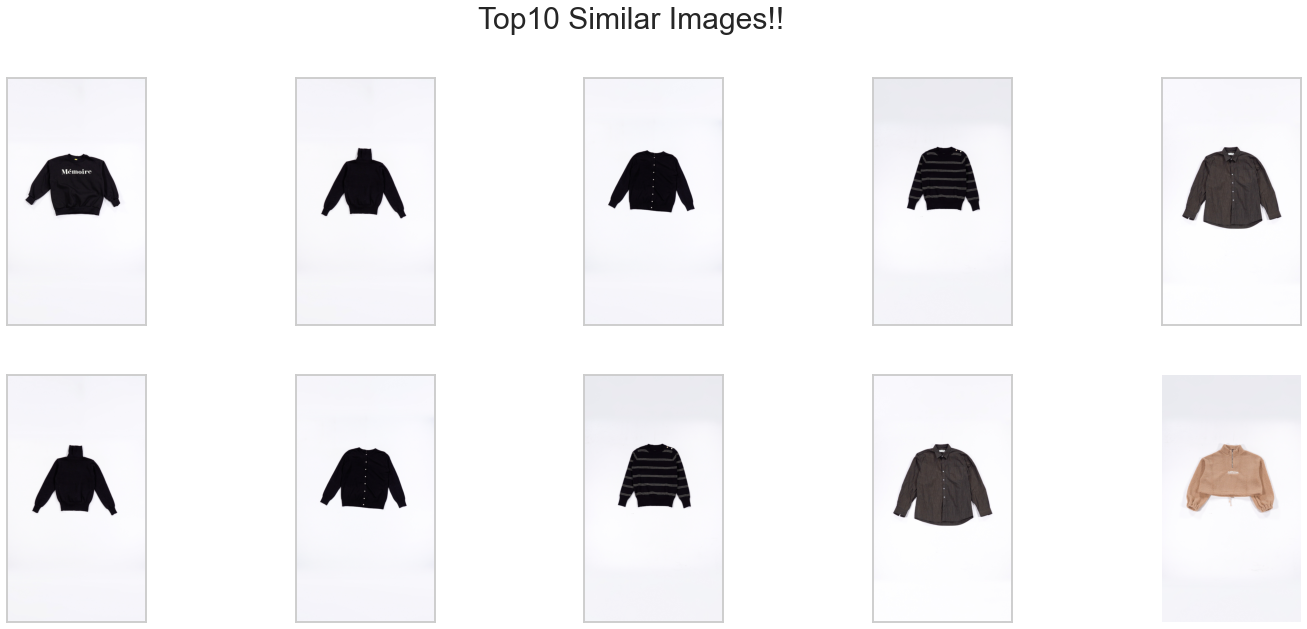

In [29]:
# Top10 Images Visualize
top10_visualize(top10_label_cosine)

## 6. Fashion Coordination Recommendation

### Fashion Coordination Dataframe Design

In [1078]:
# Train Label json file load
file_path = f'{usb_dir}labels/wearing_info_train.json'
with open(file_path, 'r') as file:
    data = json.load(file)
    print(type(data))

<class 'list'>


In [1079]:
# Train Label file dataframe
train_label = pd.DataFrame(data)
print(train_label.shape)
train_label.head()

(94088, 6)


,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013,1008011,None,1008012,None
1,1008_1008_720_A_A001_A001_044.jpg,1008013,1008011,None,1008012,None
2,1008_1008_720_A_A001_A001_088.jpg,1008013,1008011,None,1008012,None
3,1008_1008_720_A_A001_A001_132.jpg,1008013,1008011,None,1008012,None
4,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449,1029157,None,1029107,None


In [1080]:
# Valid Label json file load
file_path = f'{usb_dir}labels/wearing_info_val.json'
with open(file_path, 'r') as file:
    data = json.load(file)
    print(type(data))

<class 'list'>


In [1081]:
# Valid Label file dataframe
valid_label = pd.DataFrame(data)
print(valid_label.shape)
valid_label.head()

(11629, 6)


,wearing,hat,main_top,inner_top,bottom,shoes
0,1030_1030_720_B_B005_232_229_223_B005_000.jpg,1029430,1029329,None,1029143,None
1,1030_1030_720_B_B005_232_229_223_B005_074.jpg,1029430,1029329,None,1029143,None
2,1030_1030_720_B_B005_232_229_223_B005_148.jpg,1029430,1029329,None,1029143,None
3,1030_1030_720_B_B005_232_229_223_B005_222.jpg,1029430,1029329,None,1029143,None
4,1030_1030_720_C_C012_232_224_227_C012_000.jpg,1029458,1029165,None,1029264,None


In [1082]:
# Concat Train & Valid Label Dataframe
total_label = pd.concat([train_label,valid_label],axis=0)
print(total_label.shape)
total_label.head()

(105717, 6)


,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013,1008011,None,1008012,None
1,1008_1008_720_A_A001_A001_044.jpg,1008013,1008011,None,1008012,None
2,1008_1008_720_A_A001_A001_088.jpg,1008013,1008011,None,1008012,None
3,1008_1008_720_A_A001_A001_132.jpg,1008013,1008011,None,1008012,None
4,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449,1029157,None,1029107,None


In [1083]:
# Total label dataframe information
total_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105717 entries, 0 to 11628
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   wearing    105717 non-null  object
 1   hat        484 non-null     object
 2   main_top   105717 non-null  object
 3   inner_top  18575 non-null   object
 4   bottom     92542 non-null   object
 5   shoes      1350 non-null    object
dtypes: object(6)
memory usage: 5.6+ MB


In [1084]:
# fashion dataframe 
print(total_label.isna().sum())

wearing           0
hat          105233
main_top          0
inner_top     87142
bottom        13175
shoes        104367
dtype: int64


In [1085]:
# fashion dataframe Missing Value Imputation
total_label.fillna(0,inplace=True)
print('Remain Missing Value :',total_label.isna().sum().sum())

Remain Missing Value : 0


In [1086]:
# fashion data preprocessing
total_label.iloc[:,1:] = total_label.iloc[:,1:].astype(int)
total_label.head()

,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013,1008011,0,1008012,0
1,1008_1008_720_A_A001_A001_044.jpg,1008013,1008011,0,1008012,0
2,1008_1008_720_A_A001_A001_088.jpg,1008013,1008011,0,1008012,0
3,1008_1008_720_A_A001_A001_132.jpg,1008013,1008011,0,1008012,0
4,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449,1029157,0,1029107,0


### Fashion Coordination Dataframe Load

In [30]:
# fashion coordination dataframe
fashion_df = pd.read_csv('ConvAE_Recom/database/total_label.csv')
print('fashion_df.shape :',fashion_df.shape)
fashion_df.head()

fashion_df.shape : (105717, 6)


,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013,1008011,0,1008012,0
1,1008_1008_720_A_A001_A001_044.jpg,1008013,1008011,0,1008012,0
2,1008_1008_720_A_A001_A001_088.jpg,1008013,1008011,0,1008012,0
3,1008_1008_720_A_A001_A001_132.jpg,1008013,1008011,0,1008012,0
4,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449,1029157,0,1029107,0


In [31]:
# fashion data preprocessing
fashion_df.iloc[:,1:] = fashion_df.iloc[:,1:].astype(int)
fashion_df.head()

,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013,1008011,0,1008012,0
1,1008_1008_720_A_A001_A001_044.jpg,1008013,1008011,0,1008012,0
2,1008_1008_720_A_A001_A001_088.jpg,1008013,1008011,0,1008012,0
3,1008_1008_720_A_A001_A001_132.jpg,1008013,1008011,0,1008012,0
4,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449,1029157,0,1029107,0


### Match the Coordination

In [32]:
# top10 label by cosine similarity
top10_label_cosine

array(['1111533_F.jpg', '1111372_F.jpg', '1117035_F.jpg', '1028078_F.jpg',
       '1019143_F.jpg', '1027361_F.jpg', '1029008_F.jpg', '1201206_F.jpg',
       '1019392_F.jpg', '1210290_F.jpg'], dtype=object)

In [33]:
# top10 label preprocessing
top10_result_cosine = list(map(lambda x : int(x[:7]), top10_label_cosine))
top10_result_cosine

[1111533,
 1111372,
 1117035,
 1028078,
 1019143,
 1027361,
 1029008,
 1201206,
 1019392,
 1210290]

In [34]:
# top10 Recommendation Result
recomm_df = Fashion_coordination(top10_result_cosine, fashion_df)
print('recomm_df :',len(recomm_df),'DataFrame')
for i in range(len(recomm_df)):
    print(f"{i+1} item's coordination cases :",recomm_df[i].shape[0])

recomm_df : 10 DataFrame
1 item's coordination cases : 4
2 item's coordination cases : 4
3 item's coordination cases : 4
4 item's coordination cases : 20
5 item's coordination cases : 20
6 item's coordination cases : 6
7 item's coordination cases : 4
8 item's coordination cases : 12
9 item's coordination cases : 20
10 item's coordination cases : 4


In [35]:
# Total Similar Item Coordination DataFrame
recomm_total = pd.concat(recomm_df,axis=0)
recomm_total.reset_index(drop=True,)
print('recomm_total.shape :',recomm_total.shape)
recomm_total.head()

recomm_total.shape : (98, 6)


,wearing,hat,main_top,inner_top,bottom,shoes
45127,1112_1112_720_B_B092_381_B092_000.jpg,0,1111533,0,1111528,0
45128,1112_1112_720_B_B092_381_B092_063.jpg,0,1111533,0,1111528,0
45129,1112_1112_720_B_B092_381_B092_126.jpg,0,1111533,0,1111528,0
45130,1112_1112_720_B_B092_381_B092_189.jpg,0,1111533,0,1111528,0
44477,1112_1112_720_A_A043_266_378_A043_000.jpg,0,1111372,0,1111437,0


### Recommendation Service Output Result

<Figure size 432x288 with 0 Axes>

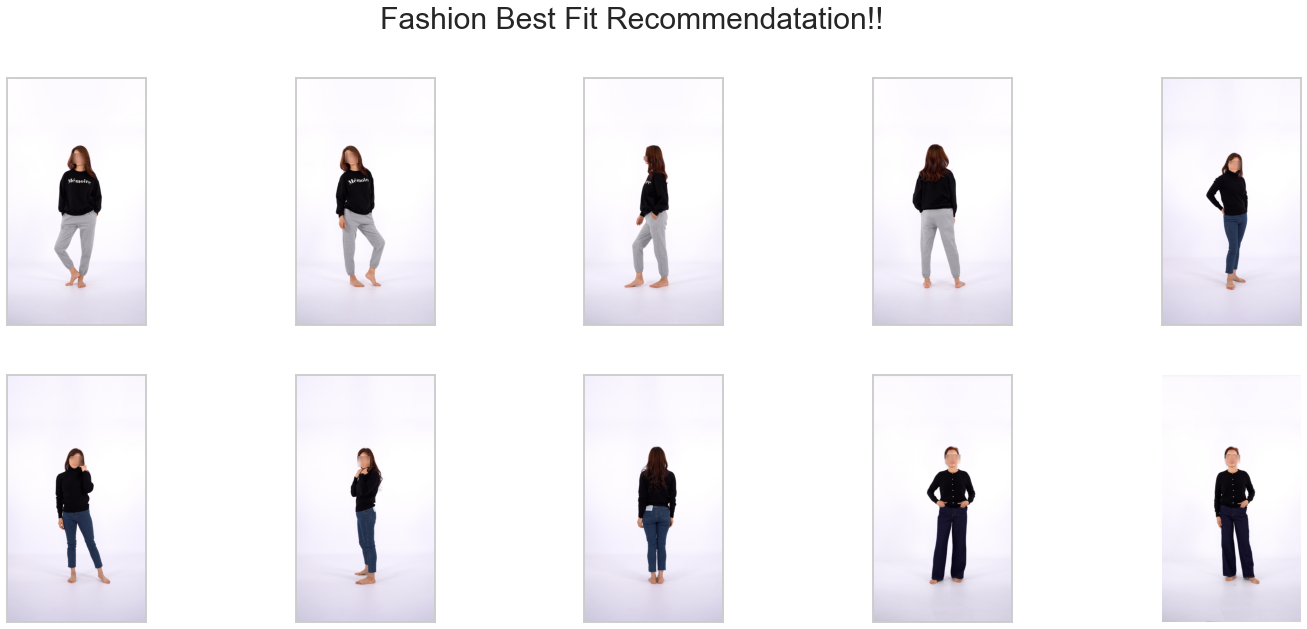

In [36]:
# Visualize Model Image of Recommendation
Recommendation_Result_Visualization(recomm_total)